<a href="https://colab.research.google.com/github/Luis-Pocholo-Caducio/MLBB_Highlights_Generator/blob/main/MLBB_Highlights_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture

!pip install pafy youtube-dl moviepy
!pip install tensorflow
!pip install keras
!pip install cv2
!pip install pygame
!pip install moviepy

In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

#from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 7

DATASET_DIR = "drive/MyDrive/mlbb dataset final"
CLASSES_LIST = ["farming", "team fight", "game ending", "lord", "turtle"]

In [ ]:
def frames_extraction(video_path):

  frames_list = []
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    success, frame = video_reader.read()

    if not success:
      break

    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frames_list.append(normalized_frame)

  video_reader.release()

  return frames_list

In [ ]:
def create_dataset():

  features = []
  labels = []
  video_files_paths = []

  for class_index, class_name in enumerate(CLASSES_LIST):
    print(f'Extracting Data of Class: {class_name}')
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

    for file_name in files_list:
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
      frames = frames_extraction(video_file_path)

      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  features = np.array(features)
  labels = np.array(labels)

  return features, labels, video_files_paths

In [ ]:
# create the preprocessed dataset
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: farming
Extracting Data of Class: team fight
Extracting Data of Class: game ending
Extracting Data of Class: lord
Extracting Data of Class: turtle


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# split the data into train (75%) and Test Set (25%)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                           test_size = 0.25, shuffle = True,
                                                                           random_state = seed_constant)

In [ ]:
# CONSTRUCTING LRCN MODEL

def create_LRCN_model():

  model = Sequential()

  model.add(TimeDistributed(Conv2D(16, (3,3), padding = 'same', activation = 'relu'),
                            input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32, (3,3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3,3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3,3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  #model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

  model.summary()

  return model

In [ ]:
LRCN_model = create_LRCN_model()

print("Model created successfully")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 7, 64, 64, 16)     448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 7, 16, 16, 16)     0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 7, 16, 16, 16)     0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 7, 16, 16, 32)     4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 7, 4, 4, 32)       0

In [ ]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 60, batch_size = 4,
                                              shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/60
30/30 [==============================] - 2s 25ms/step - loss: 1.5615 - accuracy: 0.2833 - val_loss: 1.5167 - val_accuracy: 0.5333
Epoch 2/60
30/30 [==============================] - 0s 10ms/step - loss: 1.5404 - accuracy: 0.2833 - val_loss: 1.4933 - val_accuracy: 0.3667
Epoch 3/60
30/30 [==============================] - 0s 10ms/step - loss: 1.5157 - accuracy: 0.3417 - val_loss: 1.4494 - val_accuracy: 0.3667
Epoch 4/60
30/30 [==============================] - 0s 9ms/step - loss: 1.5146 - accuracy: 0.3417 - val_loss: 1.4550 - val_accuracy: 0.3667
Epoch 5/60
30/30 [==============================] - 0s 10ms/step - loss: 1.5113 - accuracy: 0.3417 - val_loss: 1.4455 - val_accuracy: 0.3667
Epoch 6/60
30/30 [==============================] - 0s 9ms/step - loss: 1.5099 - accuracy: 0.3500 - val_loss: 1.4556 - val_accuracy: 0.3667
Epoch 7/60
30/30 [==============================] - 0s 10ms/step - loss: 1.4623 - accuracy: 0.2917 - val_loss: 1.4164 - val_accuracy: 0.3667
Epoch 8/60
30/3

In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

2/2 [==============================] - 0s 9ms/step - loss: 0.9521 - accuracy: 0.6200


In [ ]:
# Saving the Model

model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model__Date_Time){current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# PLOTTING THE MODEL'S LOSS & ACCURACY CURVES

def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  plt.title(str(plot_name))

  plt.legend()

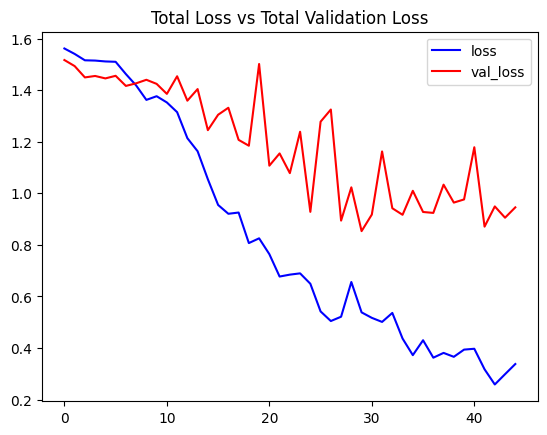

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

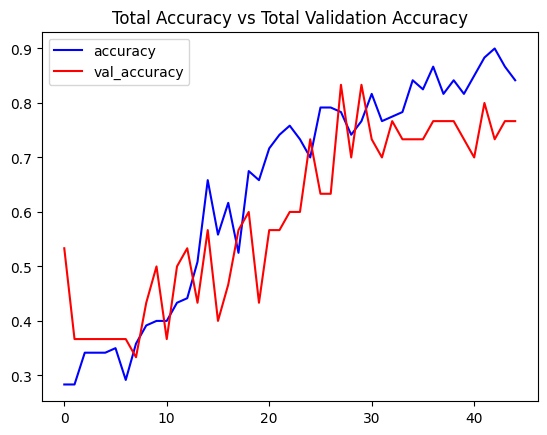

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
from keras.models import load_model
LRCN_model = load_model("/content/drive/MyDrive/LRCN_model__Date_Time)2025_01_03__16_04_05__Loss_0.45555490255355835__Accuracy_0.8796296119689941.h5")

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ITGhU0dOsQulCvRJyoV8")
project = rf.workspace("julianaworkspace-lueya").project("mlbb-banners-detection")
version = project.version(4)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MLBB-banners-detection-4 in yolov8:: 100%|██████████| 2368/2368 [00:00<00:00, 8284.36it/s]


In [ ]:
!pip install ultralytics -q

from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.9/906.9 kB 22.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO("yolov8n.pt")
model.train(
    data = "/content/MLBB-banners-detection-4/data.yaml" ,
    epochs = 10 ,
    batch = 16
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.9/906.9 kB 24.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
%%capture
!pip install moviepy

def predict_teamfights(video_file_path, SEQUENCE_LENGTH):
    import cv2
    import numpy as np
    from moviepy.video.io.VideoFileClip import VideoFileClip
    from moviepy.video.io.VideoFileClip import VideoFileClip
    from collections import deque

    video_reader = cv2.VideoCapture(video_file_path)
    target_class_name = "team fight"

    if not video_reader.isOpened():
        raise FileNotFoundError(f"Input video file {video_file_path} could not be opened.")

    fps = video_reader.get(cv2.CAP_PROP_FPS)
    frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    video_duration = frame_count / fps

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    detected_intervals = []
    is_detecting = False
    start_time = None

    while video_reader.isOpened():
        current_frame_pos = video_reader.get(cv2.CAP_PROP_POS_FRAMES)
        current_time = current_frame_pos / fps

        ok, frame = video_reader.read()
        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

            if predicted_class_name == target_class_name:
                if not is_detecting:
                    start_time = current_time
                    is_detecting = True
            else:
                if is_detecting:
                    detected_intervals.append((start_time, current_time))
                    is_detecting = False

    if is_detecting:
        detected_intervals.append((start_time, video_duration))

    video_reader.release()

    return detected_intervals


In [ ]:
from typing import List, Tuple, Dict
import cv2
import numpy as np
from dataclasses import dataclass
from pathlib import Path

@dataclass
class HighlightSegment:
    start_time: float
    end_time: float
    priority_score: int
    banners: List[str]


def detect_banners_in_intervals(
    video_path: str,
    team_fight_intervals: List[Tuple[float, float]],
    banner_model: any,
    confidence_threshold: float = 0.8,
    verbose: bool = False
) -> List[HighlightSegment]:
    priority_dict = {
        'Savage': 13,
        'Maniac': 12,
        'TripleKill': 11,
        'DoubleKill': 10,
        'FirstBlood': 9,
        'ShutDown': 8,
        'Legendary': 7,
        'GodLike': 6,
        'MonsterKill': 5,
        'Unstoppable': 4,
        'MegaKill': 3,
        'KillingSpree': 2,
        'HasSlain': 1,
        'WipedOut': 0,
        'Destroyed': 0
    }

    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        raise RuntimeError(f"Failed to open video: {video_path}")

    try:
        fps = video_reader.get(cv2.CAP_PROP_FPS)
        highlight_segments = []

        for interval_idx, (start_time, end_time) in enumerate(team_fight_intervals, 1):
            if verbose:
                print(f"\nProcessing team fight {interval_idx}/{len(team_fight_intervals)}")

            detected_banners = set()
            total_priority = 0

            start_frame = int(start_time * fps)
            end_frame = int(end_time * fps)

            video_reader.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

            for frame_idx in range(start_frame, end_frame):
                ok, frame = video_reader.read()
                if not ok:
                    break

                results = banner_model(frame, verbose=False)

                for result in results:
                    boxes = result.boxes
                    for box in boxes:
                        class_name = banner_model.names[int(box.cls[0])]
                        confidence = float(box.conf[0])

                        if confidence > confidence_threshold:
                            if class_name not in detected_banners:
                                detected_banners.add(class_name)
                                banner_priority = priority_dict.get(class_name, 0)
                                total_priority += banner_priority

                                if verbose:
                                    print(f"New banner detected: {class_name} "
                                          f"(Priority: {banner_priority})")

                if verbose and (frame_idx - start_frame) % 30 == 0:
                    progress = (frame_idx - start_frame) / (end_frame - start_frame) * 100
                    print(f"Progress: {progress:.1f}%")

            if detected_banners:
                interval_duration = end_time - start_time
                if interval_duration < 2.0:
                    adjusted_start_time = max(0, start_time - 7.0)
                    #adjusted_end_time = end_time + 2.00
                    if verbose:
                        print(f"Banner detected, but interval too short ({interval_duration:.2f}s). "
                              f"Adjusting start time from {start_time:.2f}s to {adjusted_start_time:.2f}s")
                    start_time = adjusted_start_time
                    #end_time = adjusted_end_time


            highlight_segments.append(HighlightSegment(
                start_time=start_time,
                end_time=end_time,
                priority_score=total_priority,
                banners=list(detected_banners)
            ))

        #highlight_segments.sort(key=lambda x: x.priority_score, reverse=True)

        if verbose:
            print("\nHighlight Summary:")
            for i, segment in enumerate(highlight_segments, 1):
                print(f"\nHighlight {i}:")
                print(f"Time: {segment.start_time:.2f}s - {segment.end_time:.2f}s")
                print(f"Priority Score: {segment.priority_score}")
                print("Banners Detected:")
                for banner in segment.banners:
                    print(f"  - {banner}")
                print(f"Duration: {segment.end_time - segment.start_time:.2f}s")

        return highlight_segments

    finally:
        video_reader.release()

In [ ]:
def create_highlight_video(
    video_path: str,
    highlight_segments: List[HighlightSegment],
    output_path: str,
    min_priority_score: int = 1
) -> None:

    from moviepy.video.io.VideoFileClip import VideoFileClip
    from moviepy.editor import concatenate_videoclips
    from moviepy.editor import concatenate_videoclips, VideoFileClip

    valid_segments = [seg for seg in highlight_segments if seg.priority_score >= min_priority_score]

    if not valid_segments:
        print("No highlights meet the minimum priority score requirement.")
        return

    with VideoFileClip(video_path) as video:
        clips = []

        print("\nCreating highlight video with the following segments:")
        for i, segment in enumerate(valid_segments, 1):
            print(f"\nClip {i}:")
            print(f"Time: {segment.start_time:.2f}s - {segment.end_time:.2f}s")
            print(f"Priority Score: {segment.priority_score}")
            print("Banners:", ", ".join(segment.banners))

            clip = video.subclip(segment.start_time, segment.end_time)
            clips.append(clip)

        final_video = concatenate_videoclips(clips)
        final_video.write_videofile(
            output_path,
            codec="libx264",
            verbose=False,
            logger=None
        )

    print(f"\nHighlight video saved to: {output_path}")

In [ ]:
%%capture

input_video_path="/content/drive/MyDrive/ML input vids/Game ML - 2.mp4"
SEQUENCE_LENGTH = 30

detected_teamfights = predict_teamfights(input_video_path, SEQUENCE_LENGTH)

In [ ]:
print (detected_teamfights)

[(16.566666666666666, 16.966666666666665), (17.133333333333333, 17.2), (17.233333333333334, 17.533333333333335), (18.066666666666666, 18.633333333333333), (19.2, 19.233333333333334), (22.9, 22.933333333333334), (23.3, 24.066666666666666), (32.13333333333333, 32.666666666666664), (34.3, 50.1), (50.13333333333333, 66.0), (118.6, 119.8), (123.26666666666667, 129.9), (130.03333333333333, 142.7), (146.4, 147.06666666666666), (148.16666666666666, 149.4), (149.46666666666667, 151.53333333333333), (159.46666666666667, 160.63333333333333), (186.96666666666667, 187.43333333333334), (190.46666666666667, 191.8), (194.3, 194.5), (194.96666666666667, 195.13333333333333), (204.73333333333332, 205.3), (226.6, 226.8), (230.4, 231.26666666666668), (232.63333333333333, 250.06666666666666), (250.56666666666666, 254.8), (258.0, 258.1), (258.1666666666667, 258.26666666666665), (284.53333333333336, 286.96666666666664), (287.1, 287.43333333333334), (291.7, 292.6666666666667), (292.8, 293.1333333333333), (293.

In [ ]:
banner_model = YOLO("/content/drive/MyDrive/runs/detect/train/weights/best.pt")


highlight_segments = detect_banners_in_intervals(
    video_path="/content/drive/MyDrive/ML input vids/Game ML - 3.mp4",
    team_fight_intervals=detected_teamfights,
    banner_model=banner_model,
    verbose=True
)


Processing team fight 1/196
Progress: 0.0%

Processing team fight 2/196
Progress: 0.0%

Processing team fight 3/196
Progress: 0.0%

Processing team fight 4/196
Progress: 0.0%

Processing team fight 5/196
Progress: 0.0%

Processing team fight 6/196
Progress: 0.0%

Processing team fight 7/196
Progress: 0.0%

Processing team fight 8/196
Progress: 0.0%

Processing team fight 9/196
Progress: 0.0%
Progress: 6.3%
Progress: 12.7%
Progress: 19.0%
Progress: 25.3%
Progress: 31.6%
Progress: 38.0%
Progress: 44.3%
Progress: 50.6%
Progress: 57.0%
Progress: 63.3%
Progress: 69.6%
Progress: 75.9%
Progress: 82.3%
Progress: 88.6%
Progress: 94.9%

Processing team fight 10/196
Progress: 0.0%
Progress: 6.3%
Progress: 12.6%
Progress: 18.9%
New banner detected: FirstBlood (Priority: 9)
Progress: 25.2%
New banner detected: HasSlain (Priority: 1)
Progress: 31.5%
Progress: 37.8%
Progress: 44.1%
Progress: 50.4%
Progress: 56.7%
Progress: 63.0%
Progress: 69.3%
Progress: 75.6%
Progress: 81.9%
Progress: 88.2%
Progres

In [ ]:
create_highlight_video(
    video_path="/content/drive/MyDrive/ML input vids/Game ML - 3.mp4",
    highlight_segments=highlight_segments,
    output_path="GAME ML 3_highlights_minPriority15.mp4",
    min_priority_score= 15
)


Creating highlight video with the following segments:

Clip 1:
Time: 50.13s - 66.00s
Priority Score: 20
Banners: DoubleKill, FirstBlood, HasSlain

Clip 2:
Time: 504.17s - 528.77s
Priority Score: 18
Banners: KillingSpree, Legendary, ShutDown, HasSlain

Clip 3:
Time: 882.30s - 903.77s
Priority Score: 23
Banners: DoubleKill, HasSlain, ShutDown, Unstoppable

Clip 4:
Time: 1107.10s - 1133.73s
Priority Score: 17
Banners: WipedOut, KillingSpree, Destroyed, MegaKill, TripleKill, HasSlain

Highlight video saved to: GAME ML 3_highlights_minPriority15.mp4
